# MA3J8 Approximation Theory and Applications 

## 03 - Algebraic Polynomials




In [23]:
using SoftGlobalScope, LinearAlgebra, LaTeXStrings, Plots
gr();

### 03-1 - Runge's Phenomenon

We consider the function $f : [-1, 1] \to \mathbb{R}$, 
$$
   f(x) = \frac{1}{1 + 25 x^2}
$$
Note that $f$ is analytic on $[-1,1]$, hence from our work on trigonometric approximation we expect excellent approximation properties. We choose a uniform grid, 
$$
  x_j = -1 + 2j/N, \qquad j = 0, \dots, N
$$
and interpolate $f$ at those grid points. 

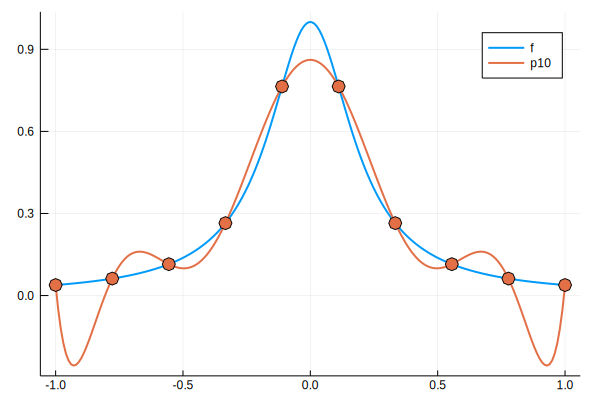

In [24]:
using Polynomials
f(x) = 1 / (1 + 25 * x^2)
N = 10
X = range(-1, stop=1, length=N)
p = polyfit(X, f.(X))
xp = range(-1, stop=1, length=200)
plot(xp, f.(xp), lw=2, label = "f")
plot!(xp, p.(xp), lw=2, label = "p$N")
plot!(X, f.(X), lw=0, m=:o, ms=6, c=2, label = "")

this does not look great. Maybe we just aren't using enough points?

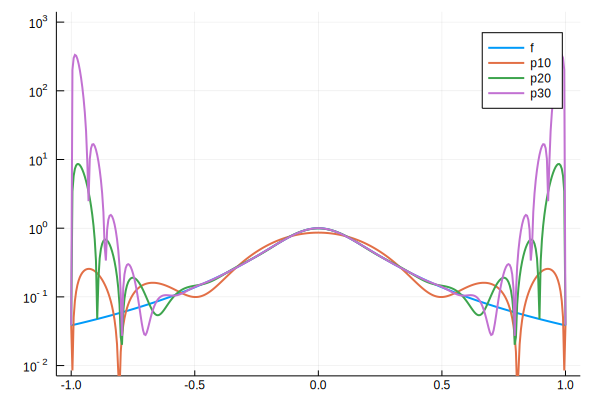

In [25]:
xp = range(-1, stop=1, length=400)
P = plot(xp, f.(xp), lw=2, label = "f")
for N in [10, 20, 30]
    X = range(-1, stop=1, length=N)
    p = polyfit(X, f.(X))
    plot!(P, xp, abs.(p.(xp)), lw=2, label = "p$N", yaxis = (:log, [1e-2, 1e3]))
end 
P

Clearly, the approximations **diverge**. This is called the Runge phenomenon. It is by no means an indicator that polynomials are poor basis functions for approximation. For example, let us use a least-squares fit w.r.t. exact function values on a fine grid. 

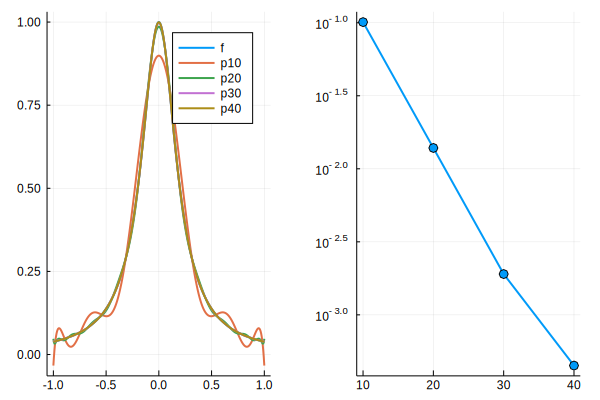

In [26]:
xp = range(-1, stop=1, length=400)
P = plot(xp, f.(xp), lw=2, label = "f")
err = []
NN = [10, 20, 30, 40]
for N in NN
    X = range(-1, stop=1, length=N)
    p = polyfit(xp, f.(xp), N)
    plot!(P, xp, p.(xp), lw=2, label = "p$N")
    push!(err, norm(f.(xp) - p.(xp), Inf))
end 
plot(P, plot(NN, err, lw=2, m=:o, yaxis = (:log,), label = ""), layout = (1,2))

We have recovered what looks like exponential convergence! Clearly there is something we need to understand.

### 03-2 Interpolation on Chebyshev Points

In the lecture notes we have motivated the Chebyshev interpolation nodes 
$$
  x_j = \cos(\pi j/ N)
$$
We can now check whether they fix the problem we had with equispaced nodes.

In [27]:
chebnodes(N) = [ cos(j*π/N) for j = N:-1:0 ]

chebnodes (generic function with 1 method)

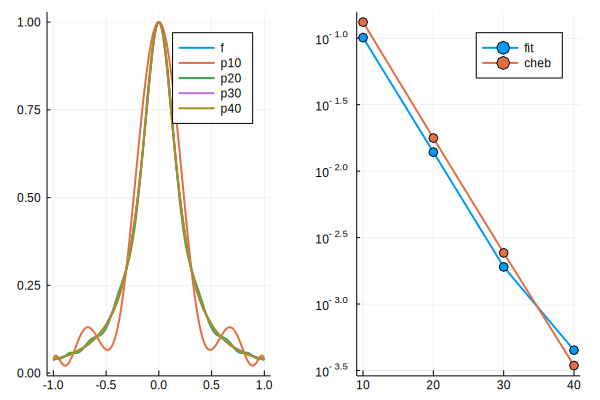

In [28]:
xp = range(-1, stop=1, length=400)
P = plot(xp, f.(xp), lw=2, label = "f")
NN = [10, 20, 30, 40]
errcheb = []
errfit = [] 
for N in NN
    X = chebnodes(N)
    pcheb = polyfit(X, f.(X))
    plot!(P, xp, pcheb.(xp), lw=2, label = "p$N")
    pfit = polyfit(xp, f.(xp), N)
    push!(errcheb, norm(f.(xp) - pcheb.(xp), Inf))
    push!(errfit, norm(f.(xp) - pfit.(xp), Inf))    
end 
plot(P, 
     plot(NN, [errfit, errcheb], lw=2, m=:o, 
          label = ["fit", "cheb"], yaxis = (:log,)), 
     layout = (1,2))

This is excellent news. We will start from here and explore this in a lot more detail.

Next, we observe another problem: evaluating the Chebyshev interpolant is numerically unstable! (At least how it is implemented in the `Polynomials.jl` package. We will return to this later.

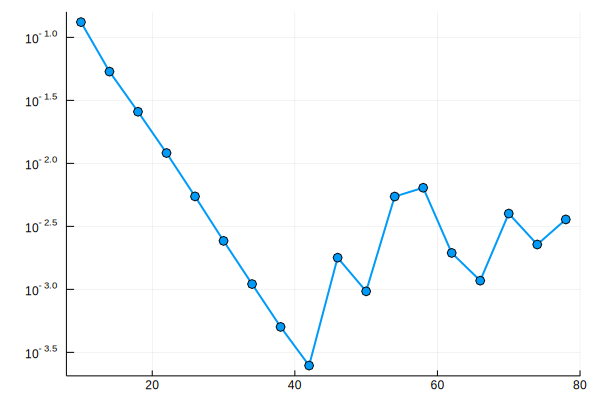

In [29]:
NN = 10:4:80
errcheb = []
for N in NN
    X = chebnodes(N)
    pcheb = polyfit(X, f.(X))
    push!(errcheb, norm(f.(xp) - pcheb.(xp), Inf))
end 
plot(NN, errcheb, lw=2, m=:o,  label = "", yaxis = (:log,))

Nevertheless, we can still explore Chebyshev interpolation on some examples - as long as we remain aware of the limitation due to numerical instability. The following results look promising but the numerical stability is clearly a severe limitation for us. We will therefore explore the errors in a little more details after implementing the barycentric formula.

In [49]:
f1(x) = 1 / (1+x^2)
f2(x) = 1 / (1+25*x^2)
f3(x) = sin(3*x)
f4(x) = abs(sin(3*x))^3
f5(x) = abs(x)
f6(x) = sign(x) * abs(x)^(3/2)
f7(x) = exp(-x^2)

fall = [f1, f2, f3, f4, f5, f6, f7]
nalg = [4,5,6]
falg = fall[nalg]
nana = [1, 2, 3, 7]
fana = fall[nana]

;

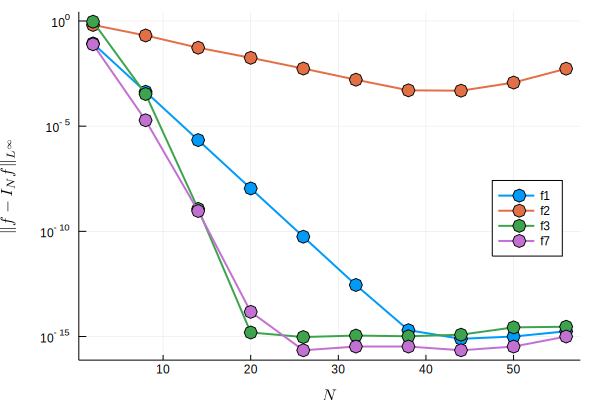

In [82]:
# Chebyshev Interpolation error for functions with exponential rates 
# ------------------------------------------------------------------
# For these functions, the convergence is fast, so we don't hit 
# the numerical instability, at least for the fast converging ones
# ------------------------------------------------------------------
NN = 2:6:60
xerr = range(-1, stop=1, length=1_000)
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"), 
         legend=:right)
for (f, n) in zip(fana, nana)
    err = []
    for N in NN 
        X = chebnodes(N)
        p = polyfit(X, f.(X))
        push!(err, norm(f.(xerr) - p.(xerr), Inf))
    end
    plot!(P, NN, err, lw=2, m=:o, ms=6, label = "f$n")
end 
P

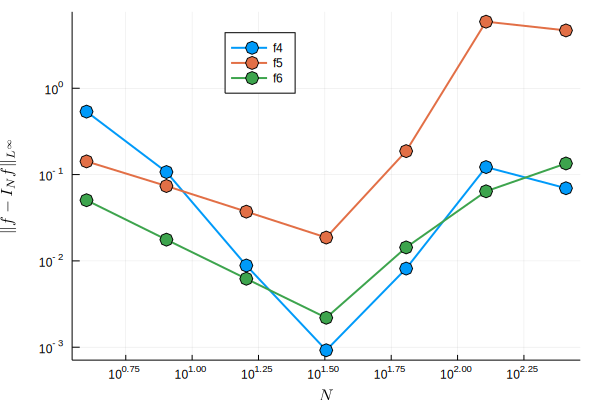

In [83]:
# Chebyshev Interpolation error for functions with algebraic rates 
# ---------------------------------------------------------------
# But for the more slowly converging tests, we get into the 
# regime of numerical instability very quickly
# ---------------------------------------------------------------

NN = (2).^(2:8)
xerr = range(-1, stop=1, length=1_000)
P = plot(xaxis = (:log, L"N"), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"), 
         legend=:top)
for (f, n) in zip(falg, nalg)
    err = []
    for N in NN 
        X = chebnodes(N)
        p = polyfit(X, f.(X))
        push!(err, norm(f.(xerr) - p.(xerr), Inf))
    end
    plot!(P, NN, err, lw=2, m=:o, ms=6, label = "f$n")
end 
P

## 03-3 Barycentric Formula

In Sec. 4.4 we derived the baycentric interpolation formula and showed that one of its variants is numerically stable. As a matter of fact, both are stable but for the one we are using here this is a little more involved to prove. Here, we implement the specific formula for chebyshev points.

In [87]:
"""
Barycentric interpolation with a Chebyshev grid with N grid points.
The interpolant is evaluated at points `x`.
"""
function bary(f, N, x)
    X = chebnodes(N)
    F = f.(X)
    p = 0.5 * ( F[1] ./ (x .- X[1]) + (-1)^N * F[N+1] ./(x .- X[N+1]) )
    q = 0.5 * (1.0 ./ (x .- X[1]) + (-1)^N ./ (x .- X[N+1]))
    for n = 1:N-1
        p += (-1)^n * F[n+1] ./ (x .- X[n+1])
        q += (-1)^n ./ (x .- X[n+1])
    end 
    return p ./ q    
end

"""
generate a grid on which to plot errors; this is chosen to avoid 
any grid points since barycentric interpolation is not defined 
on those.
"""
errgrid(Np) = range(-1+0.0123, stop=1-0.00321, length=Np)

errgrid

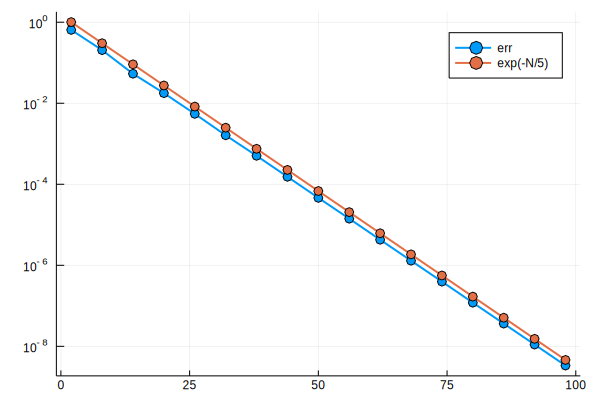

In [92]:
# back to our opening example : no sign of instability, 
# and we  get precisely the prediced rate.
# ------------------------------------------------------
f(x) = 1/(1+25*x^2)
xp = errgrid(1000)
NN = 2:6:100
err = [ norm(f.(xp) - bary(f, N, xp), Inf) for N = NN]
pred = 1.5*exp.(-NN/5)
plot(NN, [err, pred], lw=2, m=:o, 
    label=["err", "exp(-N/5)"], yaxis = (:log,))

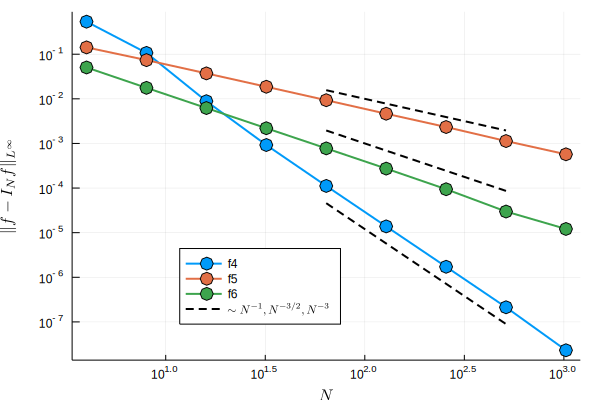

In [95]:
# The algebraically converging functions revisited, 
# this time with the predicted slopes 
# ---------------------------------------------------
NN = (2).^(2:10)
xerr = range(-1+0.00012, stop=1-0.000032, length=1_000)
P = plot(xaxis = (:log, L"N"), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"), 
         legend=:bottom)
for (f, n) in zip(falg, nalg)
    err = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N in NN ]
    plot!(P, NN, err, lw=2, m=:o, ms=6, label = "f$n")
end 
t = [NN[5], NN[8]]
plot!(P, t, 1*t.^(-1.), lw=2, ls=:dash, c=:black, label=L"\sim N^{-1}, N^{-3/2}, N^{-3}")
plot!(P, t, t.^(-3/2), lw=2, ls=:dash, c=:black, label="")
plot!(P, t, 12*t.^(-3.), lw=2, ls=:dash, c=:black, label="")
P

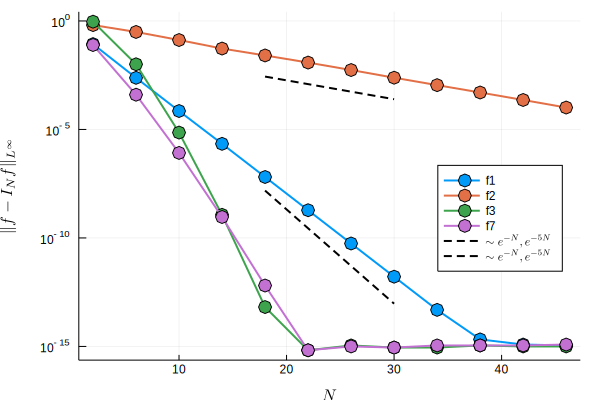

In [109]:
# the exponentially convergent functions revisited 
# f1, f2 get the prediced slopes, 
# f3, f7 are entire
# ---------------------------------------------------
NN = 2:4:46
xerr = range(-1+0.00012, stop=1-0.000032, length=1_000)
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"), 
         legend=:right)
for (f, n) in zip(fana, nana)
    err = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N in NN ]
    plot!(P, NN, err, lw=2, m=:o, ms=6, label = "f$n")
end 
t = [NN[5], NN[8]]
plot!(P, t, [exp.(-t), 0.1*exp.(-t/5)], 
      lw=2, ls=:dash, c=:black, 
      label=L"\sim e^{-N}, e^{-5N}")
P

## 03-4 Applications

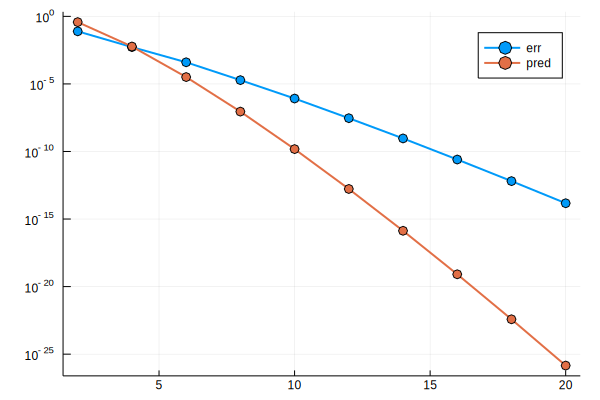

In [118]:
f(x) = exp(-x^2)
xp = errgrid(1000)
NN = 2:2:20
err = [ norm(f.(xp) - bary(f, N, xp), Inf) for N = NN]
pred = 1.5*exp.(-NN.*log.(NN))
plot(NN, [err, pred], lw=2, m=:o, 
    label=["err", "pred"], yaxis = (:log,))